In [1]:
import matplotlib.pyplot as plot
import scipy.stats as stats
import numpy
import math

light = "#DCBCBC"
light_highlight = "#C79999"
mid = "#B97C7C"
mid_highlight = "#A25050"
dark = "#8F2727"
dark_highlight = "#7C0000"
green = "#00FF00"

To facilitate the computation of Markov chain Monte Carlo estimators let's define a _Welford accumulator_ that computes empirical summaries of a sample in a single pass

In [2]:
def welford_summary(x, L = 100):
  summary = [0] * (L + 1)
  for n in range(len(x)):
    delta = x[n] - summary[0]
    summary[0] += delta / (n + 1)
    for l in range(L):
      if n > l:
        summary[l + 1] += delta * (x[n - l] - summary[0])

  norm = 1.0 / (len(x) - 1)
  for l in range(L): summary[l + 1] *= norm
  return summary

# We can then use the Welford accumulator output to compute the
# Markov chain Monte Carlo estimators and their properties
def compute_mcmc_stats(x, L = 20):
  summary = welford_summary(x, L)
  
  mean = summary[0]
  var = summary[1]
  acov = summary[1:(L + 1)]
  
  # Compute the effective sample size
  rho_hat_s = [0] * L
  rho_hat_s[1] = acov[1] / var
  
  # First we transform our autocovariances into Geyer's initial positive sequence
  max_s = 1
  for s in [ 2 * i + 1 for i in range((L - 1) // 2) ]:
    rho_hat_even = acov[s + 1] / var
    rho_hat_odd = acov[s + 2] / var;
    
    max_s = s + 2  
    
    if rho_hat_even + rho_hat_odd > 0:
      rho_hat_s[s + 1] = rho_hat_even
      rho_hat_s[s + 2] = rho_hat_odd
    else:   
      break
  
  # Then we transform this output into Geyer's initial monotone sequence
  for s in [ 2 * i + 3 for i in range((max_s - 2)// 2) ]:
    if rho_hat_s[s + 1] + rho_hat_s[s + 2] > rho_hat_s[s - 1] + rho_hat_s[s]:
      rho_hat_s[s + 1] = 0.5 * (rho_hat_s[s - 1] + rho_hat_s[s])
      rho_hat_s[s + 2] = rho_hat_s[s + 1]
  
  ess = len(x) / (1.0 + 2 * sum(rho_hat_s))
  
  return [mean, math.sqrt(var / ess), math.sqrt(var), ess]

To generate our samples we'll use numpy's pseudo random number generator which needs to be seeded to achieve reproducible results

In [3]:
numpy.random.seed(seed=8675309)

# To ensure accurate results let's generate pretty large samples
N = 10000

# To see how results scale with dimension we'll consider
# behavior one thorugh ten dimensions
Ds = [ n + 1 for n in range(10) ]

idxs = [ idx for idx in range(Ds[-1]) for r in range(2) ]
plot_Ds = [ D + delta for D in Ds for delta in [-0.5, 0.5]]

### How does the Random Walk Metropolis algorithm perform on a target distribution with a two-dimensional Gaussian density function?

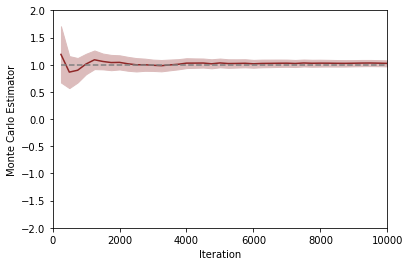

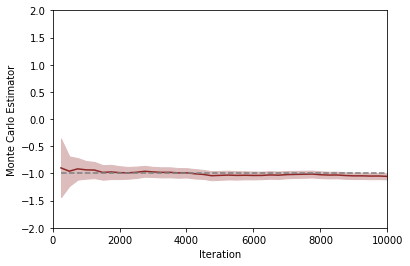

In [4]:
# Target density
def target_lpdf(x):
  return - 0.5 * ( (x[0] - 1)**2 + (x[1] + 1)**2 ) \
         - 0.5 * 2 * math.log(6.283185307179586)

# Tune proposal density
sigma = 1.4

# A place to store our Markov chain
# D columns for the parameters and one extra column
# for the Metropolis acceptance probability
D = 2
mcmc_samples = [[0] * (D + 1) for _ in range(N)]

# Randomly seed the initial state
mcmc_samples[0][0] = stats.norm.rvs(0, 3)
mcmc_samples[0][1] = stats.norm.rvs(0, 3)
mcmc_samples[0][2] = 1

for n in range(1, N):
  x0 = [ mcmc_samples[n - 1][0], mcmc_samples[n - 1][1]]
  xp = [ stats.norm.rvs(x0[0], sigma), stats.norm.rvs(x0[1], sigma) ]

  # Compute acceptance probability
  accept_prob = 1
  if target_lpdf(xp) < target_lpdf(x0):
    accept_prob = math.exp(target_lpdf(xp) - target_lpdf(x0))
  mcmc_samples[n][D] = accept_prob
  
  # Apply Metropolis correction
  u = stats.uniform.rvs(0, 1)
  if accept_prob > u:
    mcmc_samples[n][0] = xp[0]
    mcmc_samples[n][1] = xp[1]
  else:
    mcmc_samples[n][0] = x0[0]
    mcmc_samples[n][1] = x0[1]

# Compute MCMC estimator statistics, leaving
# out the first 100 samples as warmup
compute_mcmc_stats([ s[0] for s in mcmc_samples[100:] ])
compute_mcmc_stats([ s[1] for s in mcmc_samples[100:] ])

# Plot convergence of MCMC estimators for each parameter
stride = 250
M = N // stride

iters = [ stride * (i + 1) for i in range(N // stride) ]

x1_mean = [0] * M 
x1_se = [0] * M

x2_mean = [0] * M
x2_se = [0] * M

for m in range(M):
  running_samples = [ s[0] for s in mcmc_samples[100:iters[m]] ]
  mcmc_stats = compute_mcmc_stats(running_samples)
  x1_mean[m] = mcmc_stats[0]
  x1_se[m] = mcmc_stats[1]
  
  running_samples = [ s[1] for s in mcmc_samples[100:iters[m]] ]
  mcmc_stats = compute_mcmc_stats(running_samples)
  x2_mean[m] = mcmc_stats[0]
  x2_se[m] = mcmc_stats[1]

plot.fill_between(iters, 
                  [ x1_mean[m] - 2 * x1_se[m] for m in range(M) ],
                  [ x1_mean[m] + 2 * x1_se[m] for m in range(M) ],
                  facecolor=light, color=light)
plot.plot(iters, x1_mean, color=dark)
plot.plot([iters[0], iters[-1]], [1, 1], color='grey', linestyle='--')

plot.gca().set_xlim([0, N])
plot.gca().set_xlabel("Iteration")
plot.gca().set_ylim([-2, 2])
plot.gca().set_ylabel("Monte Carlo Estimator")

plot.show()

plot.fill_between(iters, 
                  [ x2_mean[m] - 2 * x2_se[m] for m in range(M) ],
                  [ x2_mean[m] + 2 * x2_se[m] for m in range(M) ],
                  facecolor=light, color=light)
plot.plot(iters, x2_mean, color=dark)
plot.plot([iters[0], iters[-1]], [-1, -1], color='grey', linestyle='--')

plot.gca().set_xlim([0, N])
plot.gca().set_xlabel("Iteration")
plot.gca().set_ylim([-2, 2])
plot.gca().set_ylabel("Monte Carlo Estimator")

plot.show()

### How does the Random Walk Metropolis algorithm perform on a target distribution with a funnel density function?

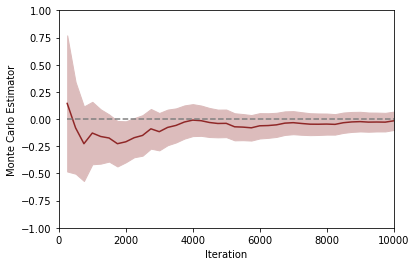

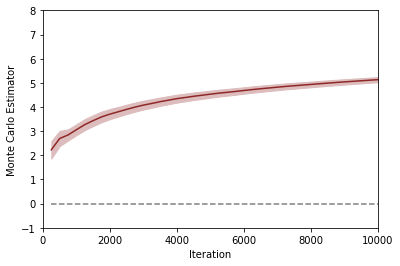

In [5]:
# Target density
def target_lpdf(x):
  return - 0.5 * ( x[0]**2 + x[1]**2 + ( (x[2] - x[0]) / math.exp(x[1]) )**2 ) \
         - 0.5 * 3 * math.log(6.283185307179586) - 0.5 * x[2]

# Tune proposal density
sigma = 1.4

# A place to store our Markov chain
# D columns for the parameters and one extra column
# for the Metropolis acceptance probability
D = 3
mcmc_samples = [[0] * (D + 1) for _ in range(N)]

# Randomly seed the initial state
mcmc_samples[0][0] = stats.norm.rvs(0, 3)
mcmc_samples[0][1] = stats.norm.rvs(0, 3)
mcmc_samples[0][2] = stats.norm.rvs(0, 3)
mcmc_samples[0][3] = 1

for n in range(1, N):
  x0 = [ mcmc_samples[n - 1][0], 
         mcmc_samples[n - 1][1], 
         mcmc_samples[n - 1][2]]
  xp = [ stats.norm.rvs(x0[0], sigma), 
         stats.norm.rvs(x0[1], sigma),
         stats.norm.rvs(x0[2], sigma) ]

  # Compute acceptance probability
  accept_prob = 1
  if target_lpdf(xp) < target_lpdf(x0):
    accept_prob = math.exp(target_lpdf(xp) - target_lpdf(x0))
  mcmc_samples[n][D] = accept_prob
  
  # Apply Metropolis correction
  u = stats.uniform.rvs(0, 1)
  if accept_prob > u:
    mcmc_samples[n][0] = xp[0]
    mcmc_samples[n][1] = xp[1]
    mcmc_samples[n][2] = xp[2]
  else:
    mcmc_samples[n][0] = x0[0]
    mcmc_samples[n][1] = x0[1]
    mcmc_samples[n][2] = x0[2]

# Compute MCMC estimator statistics, leaving
# out the first 100 samples as warmup
compute_mcmc_stats([ s[0] for s in mcmc_samples[100:] ])
compute_mcmc_stats([ s[1] for s in mcmc_samples[100:] ])
compute_mcmc_stats([ s[2] for s in mcmc_samples[100:] ])

# Plot convergence of MCMC estimators for each parameter
stride = 250
M = N // stride

iters = [ stride * (i + 1) for i in range(N // stride) ]

mu_mean = [0] * M 
mu_se = [0] * M

log_tau_mean = [0] * M
log_tau_se = [0] * M

for m in range(M):
  running_samples = [ s[0] for s in mcmc_samples[100:iters[m]] ]
  mcmc_stats = compute_mcmc_stats(running_samples)
  mu_mean[m] = mcmc_stats[0]
  mu_se[m] = mcmc_stats[1]
  
  running_samples = [ s[1] for s in mcmc_samples[100:iters[m]] ]
  mcmc_stats = compute_mcmc_stats(running_samples)
  log_tau_mean[m] = mcmc_stats[0]
  log_tau_se[m] = mcmc_stats[1]

plot.fill_between(iters, 
                  [ mu_mean[m] - 2 * mu_se[m] for m in range(M) ],
                  [ mu_mean[m] + 2 * mu_se[m] for m in range(M) ],
                  facecolor=light, color=light)
plot.plot(iters, mu_mean, color=dark)
plot.plot([iters[0], iters[-1]], [0, 0], color='grey', linestyle='--')

plot.gca().set_xlim([0, N])
plot.gca().set_xlabel("Iteration")
plot.gca().set_ylim([-1, 1])
plot.gca().set_ylabel("Monte Carlo Estimator")

plot.show()

plot.fill_between(iters, 
                  [ log_tau_mean[m] - 2 * log_tau_se[m] for m in range(M) ],
                  [ log_tau_mean[m] + 2 * log_tau_se[m] for m in range(M) ],
                  facecolor=light, color=light)
plot.plot(iters, log_tau_mean, color=dark)
plot.plot([iters[0], iters[-1]], [0, 0], color='grey', linestyle='--')

plot.gca().set_xlim([0, N])
plot.gca().set_xlabel("Iteration")
plot.gca().set_ylim([-1, 8])
plot.gca().set_ylabel("Monte Carlo Estimator")

plot.show()

### How does the effective sample size of a Random Walk Metropolis Markov chain vary with the dimension of the target distribution?

In [6]:
def target_lpdf(x):
  return - 0.5 * sum([ x_n**2 for x_n in x ]) \
         - 0.5 * len(x) * math.log(6.283185307179586)

First let's use a constant Markov transition

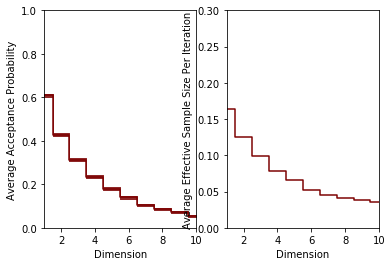

In [7]:
accept_prob_means = [0] * len(Ds)
accept_prob_ses = [0] * len(Ds)
ave_eff_sample_sizes = [0] * len(Ds)

# Tune proposal density
sigma = 1.4

for D in Ds:
  # A place to store our Markov chain
  # D columns for the parameters and one extra column
  # for the Metropolis acceptance probability
  mcmc_samples = [[0] * (D + 1) for _ in range(N)]
  
  # Seeding the initial state with an exact sample
  # from the target distribution ensures that we
  # start in the typical set and avoid having to
  # worry about warmup.
  for d in range(D):
    mcmc_samples[0][d] = stats.norm.rvs(0, 3)
  mcmc_samples[0][D] = 1
  
  for n in range(1, N):
    x0 = [ mcmc_samples[n - 1][d] for d in range(D) ] 
    xp = [ stats.norm.rvs(x0[d], sigma) for d in range(D) ]
  
    # Compute acceptance probability
    accept_prob = 1
    if target_lpdf(xp) < target_lpdf(x0):
      accept_prob = math.exp(target_lpdf(xp) - target_lpdf(x0))
    mcmc_samples[n][D] = accept_prob

    # Apply Metropolis correction
    u = stats.uniform.rvs(0, 1)
    if accept_prob > u:
      mcmc_samples[n][0:D] = xp
    else:
      mcmc_samples[n][0:D] = x0
  
  # Estimate average acceptance probability
  
  # Compute MCMC estimator statistics
  mcmc_stats = compute_mcmc_stats([ s[D] for s in mcmc_samples])
  
  accept_prob_means[D - 1] = mcmc_stats[0]
  accept_prob_ses[D - 1] = mcmc_stats[1]
  
  # Estimate effective sample size
  eff_sample_sizes = [ compute_mcmc_stats([ s[d] for s in mcmc_samples])[3] \
                       for d in range(D) ]
  ave_eff_sample_sizes[D - 1] = sum(eff_sample_sizes) / D

f, axarr = plot.subplots(1, 2)
    
axarr[0].set_title("")
axarr[0].fill_between(plot_Ds, 
                      [ accept_prob_means[idx] - 2 * accept_prob_ses[idx] for idx in idxs ],
                      [ accept_prob_means[idx] + 2 * accept_prob_ses[idx] for idx in idxs ],
                      facecolor=dark, color=dark)
axarr[0].plot(plot_Ds, [ accept_prob_means[idx] for idx in idxs], color=dark_highlight)
axarr[0].set_xlim([Ds[0], Ds[-1]])
axarr[0].set_xlabel("Dimension")
axarr[0].set_ylim([0, 1])
axarr[0].set_ylabel("Average Acceptance Probability")

axarr[1].set_title("")
axarr[1].plot(plot_Ds, [ ave_eff_sample_sizes[idx] / N for idx in idxs],
              color=dark_highlight)
axarr[1].set_xlim([Ds[0], Ds[-1]])
axarr[1].set_xlabel("Dimension")
axarr[1].set_ylim([0, 0.3])
axarr[1].set_ylabel("Average Effective Sample Size Per Iteration")

plot.show()


Now let's use an (approximately) optimally tuned Markov transition for each dimension

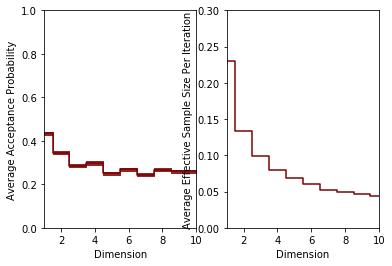

In [8]:
accept_prob_means = [0] * len(Ds)
accept_prob_ses = [0] * len(Ds)
ave_eff_sample_sizes = [0] * len(Ds)

# Approximately optimal proposal tuning
opt_sigmas = [2.5, 1.75, 1.5, 1.2, 1.15, 1.0, 0.95, 0.85, 0.8, 0.75]

# Tune proposal density
sigma = 1.4

for D in Ds:
  # A place to store our Markov chain
  # D columns for the parameters and one extra column
  # for the Metropolis acceptance probability
  mcmc_samples = [[0] * (D + 1) for _ in range(N)]
  
  # Seeding the initial state with an exact sample
  # from the target distribution ensures that we
  # start in the typical set and avoid having to
  # worry about warmup.
  for d in range(D):
    mcmc_samples[0][d] = stats.norm.rvs(0, 3)
  mcmc_samples[0][D] = 1
  
  for n in range(1, N):
    x0 = [ mcmc_samples[n - 1][d] for d in range(D) ] 
    xp = [ stats.norm.rvs(x0[d], opt_sigmas[D - 1]) for d in range(D) ]
  
    # Compute acceptance probability
    accept_prob = 1
    if target_lpdf(xp) < target_lpdf(x0):
      accept_prob = math.exp(target_lpdf(xp) - target_lpdf(x0))
    mcmc_samples[n][D] = accept_prob

    # Apply Metropolis correction
    u = stats.uniform.rvs(0, 1)
    if accept_prob > u:
      mcmc_samples[n][0:D] = xp
    else:
      mcmc_samples[n][0:D] = x0
  
  # Estimate average acceptance probability
  
  # Compute MCMC estimator statistics
  mcmc_stats = compute_mcmc_stats([ s[D] for s in mcmc_samples])
  
  accept_prob_means[D - 1] = mcmc_stats[0]
  accept_prob_ses[D - 1] = mcmc_stats[1]
  
  # Estimate effective sample size
  eff_sample_sizes = [ compute_mcmc_stats([ s[d] for s in mcmc_samples])[3] \
                       for d in range(D) ]
  ave_eff_sample_sizes[D - 1] = sum(eff_sample_sizes) / D

f, axarr = plot.subplots(1, 2)
    
axarr[0].set_title("")
axarr[0].fill_between(plot_Ds, 
                      [ accept_prob_means[idx] - 2 * accept_prob_ses[idx] for idx in idxs ],
                      [ accept_prob_means[idx] + 2 * accept_prob_ses[idx] for idx in idxs ],
                      facecolor=dark, color=dark)
axarr[0].plot(plot_Ds, [ accept_prob_means[idx] for idx in idxs], color=dark_highlight)
axarr[0].set_xlim([Ds[0], Ds[-1]])
axarr[0].set_xlabel("Dimension")
axarr[0].set_ylim([0, 1])
axarr[0].set_ylabel("Average Acceptance Probability")

axarr[1].set_title("")
axarr[1].plot(plot_Ds, [ ave_eff_sample_sizes[idx] / N for idx in idxs],
              color=dark_highlight)
axarr[1].set_xlim([Ds[0], Ds[-1]])
axarr[1].set_xlabel("Dimension")
axarr[1].set_ylim([0, 0.3])
axarr[1].set_ylabel("Average Effective Sample Size Per Iteration")

plot.show()